# Creating the Vocabulary

In [1]:
import spacy
spacy_eng = spacy.load("en")
class Vocabulary:
    PAD_token = 0   # Used for padding short sentences
    SOS_token = 1   # Start-of-sentence token
    EOS_token = 2   # End-of-sentence token

    def __init__(self, name):
        self.name = name
        self.word2index = {'PAD': 0, 'SOS': 1, 'EOS': 2, 'UNK':3}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS", 3: "UNK"}
        self.num_words = 4
        self.num_sentences = 0 
        self.longest_sentence = 0
    


    def add_word(self, word):
        
        if word not in self.word2count:
            # First entry of word into vocabulary
            self.word2count[word] = 1
        else:
            if self.word2count[word]== 5:
                self.word2index[word] = self.num_words
                self.index2word[self.num_words] = word
                self.num_words += 1
                self.word2count[word] +=1
            else:
                self.word2count[word] += 1
        
        
        
        '''
        if word not in self.word2index:
            # First entry of word into vocabulary
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            # Word exists; increase word count
            self.word2count[word] += 1
       '''     
    def tokenizer(self,text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]
    
    def add_sentence(self, sentence):
        sentence_len = 0
        #for word in sentence.split(' '):
        for word in self.tokenizer(sentence):
            sentence_len += 1
            self.add_word(word)
        if sentence_len > self.longest_sentence:
            # This is the longest sentence
            self.longest_sentence = sentence_len
        # Count the number of sentences
        self.num_sentences += 1

    def to_word(self, index):
        return self.index2word[index]

    def to_index(self, word):
        return self.word2index[word]

In [2]:
import pandas as pd
import re
df = pd.read_csv('../input/flickr-image-dataset/flickr30k_images/results.csv',delimiter='|')
df[' comment'] = df[' comment'].str.lower()
df[' comment'].replace( { r'[^a-zA-Z0-9, ]' : '' }, inplace= True, regex = True)

# fixing an issue in the dataset.
df[' comment_number'][19999] = 4
df[' comment'][19999] = ' a dog runs across the grass '

# creating the vocabulary 
vocab = Vocabulary('test')

# adding words to the vocabulary 
for sentence in df[' comment']:
    vocab.add_sentence(sentence)

# converting the captions to tokens 
sent_idxs = []
captions = []
for idx, sentence in enumerate (df[' comment']):
    i = 0
    
    for word in vocab.tokenizer(sentence):
        if word not in vocab.word2index:
            sent_idxs.append(3)
        else:
            sent_idxs.append(vocab.to_index(word))
        i+=1
    while i < ((vocab.longest_sentence) + 1):
        sent_idxs.append(0)
        i+=1
    captions.append(sent_idxs)
    sent_idxs = []

# converting list of word tokens to numpy array
import numpy as np
captions = np.array(captions)
captions.shape

(158915, 83)

In [3]:
# adding start and end tokens
for i in range(len(captions)):
    for j in range(1,84):
        if captions[i,j] == 0:
            if captions[i,j-1] == 4:
                captions[i,j-1] = 2
            else:
                captions[i,j] = 2
            break  
captions[:,0] = 1

In [4]:
vocab.num_words

7075

# Loading the embeddings

In [5]:
import numpy as np 
vocabs = vocab.word2index.keys()

def load_embeds(root_dir):
    embeddings_index = dict()
    f = open(root_dir)

    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

    f.close()
    return embeddings_index
embeddings_index = load_embeds('../input/glove6b300dtxt/glove.6B.300d.txt')

In [6]:
embeddings_index['the']

array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

In [7]:
import torch
def load_embed_weights(embeddings_index, embed_dim, vocab, vocab_size):
    matrix_len = vocab_size
    weights_matrix = np.zeros((matrix_len, embed_dim))
    words_found = 0

    for i, word in enumerate(vocab):
        try: 
            weights_matrix[i] = embeddings_index[word]
            words_found += 1
        except KeyError:
            weights_matrix[i] = np.random.normal(scale=0.6, size=(embed_dim, ))
    weights_matrix = torch.tensor(weights_matrix)
    return weights_matrix
weights_matrix = load_embed_weights(embeddings_index, 300, vocabs, vocab.num_words)
weights_matrix.shape

torch.Size([7075, 300])

# Some helper functions which we will be using later

In [8]:
def output_to_caption(outputs, index):
    preds = outputs[index]
    preds = torch.argmax(preds, dim = 1)
    preds = preds.cpu()
    preds = np.array(preds)
    for index in preds:
        if index == 2:
            break    
        if index != 1:    
            print(vocab.to_word(index), end = ' ')

def tensor_to_caption(preds, index):
    preds = preds[index].cpu()
    preds = np.array(preds)
    for index in preds:
        if index == 2:
            break
        if index != 1:    
            print(vocab.to_word(index), end = ' ')

def tensor_to_image(img_list, index):
    img = img_list[index].permute(1,2,0)
    plt.figure()
    plt.imshow(img.cpu())

# Creating the dataloader

a man in a black coat walks past a red UNK with a parking ticket stuck to its window 

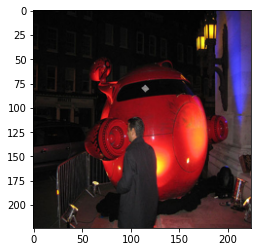

In [9]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from glob import glob
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class Data(Dataset):

    def __init__(self, root_dir, captions):
        
        self.root_dir = root_dir
        self.df = pd.read_csv(root_dir+'results.csv', delimiter = '|')
        self.captions_tensor = torch.tensor(captions)
        self.captions = captions
        self.imgloc = self.df['image_name']
        self.img_list = glob(root_dir+'flickr30k_images/*')
    
    def __getcaption__(self,index):
        return self.captions[5*index]
    
    def __getitem__(self,index):
        
        img = self.root_dir+'flickr30k_images/'+ self.imgloc[5*index]
        caption = self.captions[5*index]
        img_tensor = (torch.tensor(np.array(Image.open(img).resize((224,224)))).permute(2,0,1) )/255
        return img_tensor, caption
    
    def __len__(self):
        return (len(self.img_list)-2)


data = Data('../input/flickr-image-dataset/flickr30k_images/', captions)
img, caption_tensor = data.__getitem__(69)
caption = data.__getcaption__(69)
plt.imshow(img.permute(1,2,0))
for idx in caption:
    if idx == 1:
        continue
    if idx !=2:
        print(vocab.to_word(idx), end =" ")
    else:
        break

a young girl wearing a pink and orange striped shirt extends her arms forward and appears to be happy 

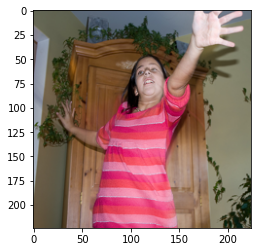

In [10]:
batch_size = 32
data_len = len(data)
trainset, valset = random_split(data, [int(0.8*data_len), (data_len - int(0.8*data_len))])
trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle = True)
valloader = DataLoader(dataset=valset, batch_size=batch_size, shuffle = True)
for img_list, caption in trainloader:
    plt.imshow(img_list[4].permute(1,2,0))
    tensor_to_caption(caption,4)
    break

# Encoder

In [11]:
import torchvision
import torch.nn as  nn

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet50(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model = torch.nn.Sequential(*(list(self.model.children())[:-2]))
    def forward(self, x):
        return self.model(x)

encoder = Encoder()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# Attention (soft)

In [12]:
class attention(nn.Module):
  def __init__(self, feature_dim, hidden_dim, embed_dim, num_vecs):
    super().__init__()
    
    self.features_fc = nn.Linear(feature_dim, num_vecs)
    self.hidden_fc = nn.Linear(hidden_dim, num_vecs)
    self.context_fc = nn.Linear(num_vecs, 1)
    self.input_fc = nn.Linear(embed_dim, hidden_dim)
    self.hidden_gate_fc = nn.Linear(hidden_dim, hidden_dim)
    self.s_fc = nn.Linear(hidden_dim, num_vecs)
    self.ones = torch.ones(num_vecs,1).to(device)
    self.tanh = torch.tanh
    self.sigma = torch.sigmoid
  
  def forward(self, features, hidden, inputs, memory):

    c1 = []
    #c1 = c1.to(device)
    for i in range(features.shape[0]):
      f = self.features_fc(features[i,:,:])            #3,3
      h = self.hidden_fc(hidden[i,:].unsqueeze(0))     #1,3
      h1 = self.ones @ h
      c = self.tanh(f+h1)                               #3,3
      z = self.context_fc(c).permute((1,0))            #1,3
      a = F.softmax(z, dim = 1)
      test = a @ features[i,:,:]

    
      gate = self.sigma( self.input_fc(inputs[i,:]) + self.hidden_gate_fc(hidden[i,:]) )
      s = gate * self.tanh(memory[i,:])                
  
      ws = self.s_fc(s.unsqueeze(0))                   #1,3
      
      w = self.tanh(ws+h)                              #1,3
      i = self.context_fc(w)                           
      
      concat = F.softmax(torch.cat((z,i), dim = 1), dim = 1).squeeze(0)
      b = concat[-1]
  
      c1b = b*s + (1-b)*(test)
      c1.append(c1b)


    c1 = torch.stack(c1)

    return  c1.squeeze(1)


# Decoder

In [13]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, weights_matrix, device, num_layers=1):
        super(Decoder, self).__init__()
        
        # define the properties
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
        # lstm cell
        #self.lstm_cell = nn.LSTMCell(input_size = embed_size + hidden_size, hidden_size=hidden_size)
        self.lstm_cell = nn.LSTMCell(input_size = embed_size, hidden_size=hidden_size)
        # output fully connected layer
        self.fc_out = nn.Linear(in_features = self.hidden_size*2, out_features = self.vocab_size)
    
        # embedding layer
        self.embed = nn.Embedding(num_embeddings = self.vocab_size, embedding_dim = self.embed_size)
        self.embed.weight.requires_grad = False
        self.embed.load_state_dict({'weight': weights_matrix})
        
        self.attn = attention(2048, 2048, 300, 49).to(device)
        
        #self.embed_test = nn.Embedding(num_embeddings = self.vocab_size, embedding_dim = self.embed_size)
        #self.embed_test.weight.requires_grad = False
        #self.embed_test.load_state_dict({'weight': weights_matrix})
         
    def forward(self, features, captions, test = False):


        # features = [32,196,512], captions = [32,num_words]
        
        # batch size
        batch_size = features.size(0)    # 32
        
        # init the hidden and cell states to zeros
        
        #hidden_state = torch.zeros((batch_size, self.hidden_size)).to(device)    #[32,512]
        #cell_state = torch.zeros((batch_size, self.hidden_size)).to(device)      #[32,512]
        
        hidden_state = torch.mean(features, dim = 1)    #[32,512]
        cell_state = torch.mean(features, dim = 1)      #[32,512]
        states = (hidden_state, cell_state)
        outputs = torch.empty((batch_size, captions.size(1), self.vocab_size)).to(device) #captions.size(1) is the number of words 
        # outputs = [32,num_words,vocab_size]
        
        # embed the captions
        captions_embed = self.embed(captions)    #[32,num_words,300]
        
        # pass the caption word by word
        if test == False: 
            for t in range(captions.size(1)):

                # getting the features of the image to be focussed on  
                #context = attn(features, hidden_state)  #[32,512]

                # concatnating it with the input word
                #inputs = torch.cat((context, captions_embed[:, t, :]), dim = 1) # [32,812] 

                #passing the combination through lstm
                #hidden_state, cell_state = self.lstm_cell(inputs, (hidden_state, cell_state))
                hidden_state, cell_state = self.lstm_cell(captions_embed[:,t,:], (hidden_state, cell_state))


                context = self.attn(features, hidden_state, captions_embed[:,t,:], cell_state)

                out = torch.cat((context, hidden_state), dim = 1)
                # output of the attention mechanism
                out = self.fc_out(out)

                # build the output tensor
                outputs[:, t, :] = out      

            return F.log_softmax(outputs, dim = 2)
        
        

        
    
        else:
            
            word_idxs = torch.ones(batch_size).long().to(device)
            
            
            for i in range(captions.size(1)):
                
                word_embeds = self.embed(word_idxs)     #[32,300]
            
                
                hidden_state, cell_state = self.lstm_cell(word_embeds, (hidden_state, cell_state))


                context = self.attn(features, hidden_state, word_embeds, cell_state)

                out = torch.cat((context, hidden_state), dim = 1)
                # output of the attention mechanism
                out = self.fc_out(out)
            
                # build the output tensor
                outputs[:, i, :] = out
                
                word_idxs = torch.argmax(out, dim = 1)
                

            return F.log_softmax(outputs, dim = 2)

              
            
        
        
        
vocab_size = vocab.num_words
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#attn = attention(2048, 2048, 300, 49)
#attn = attn.to(device)
decoder = Decoder(300,2048, vocab_size,weights_matrix, device)

# Training function

In [14]:
import pyprind
def train(encoder, decoder, trainloader, criterion, optimizer_decoder, epoch, device):
    best_loss = 100
    train_loss = []
    bar = pyprind.ProgBar(len(trainloader), bar_char='█')
    for idx, (img_list, caption) in enumerate (trainloader):

        img_list = img_list.to(device)
        caption_target = caption[:,1:]    # skips SOS
        caption_train = caption[:,:-1]    # skips EOS
        caption_target, caption_train = caption_target.to(device).long(), caption_train.to(device).long()
        features = encoder(img_list) # [32,512,49,49]
        features = features.permute(0,2,3,1)    # [32,7,7,2048]
        features = features.view(-1, 49, 2048) # [32,196,512]
        outputs = decoder(features, caption_train)
        #optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()
        
        loss = criterion(outputs.view(-1, vocab_size), caption_target.contiguous().view(-1))
        
        train_loss.append(loss.item())
        
        loss.backward()
        #optimizer_encoder.step()
        optimizer_decoder.step()
        bar.update()
        
        
    print('\ntrain loss : {}\n'.format(np.mean(train_loss)))
    if np.mean(train_loss) < best_loss:
        best_loss = np.mean(train_loss)
        torch.save(decoder.state_dict(), 'final_run1.pth')
    print('\npredicted caption:')
    output_to_caption(outputs, 1)
    print("\n\nactual caption:")
    tensor_to_caption(caption, 1)
    print()

# Training

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.NLLLoss(ignore_index = 0 )
criterion.to(device)
#encoder = model
optimizer_decoder = torch.optim.Adam(decoder.parameters(), lr = 1e-2)
#optimizer_encoder = torch.optim.Adam(encoder.parameters(), lr = 1e-2)
encoder.to(device)
decoder.to(device)
epochs = 6
decoder.load_state_dict(torch.load('../input/final-run2/final_run2.pth'))
for epoch in range(epochs):
    train(encoder, decoder, trainloader, criterion, optimizer_decoder, epoch, device)
print("OVERALL TRAINING COMPLETE")
    

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 01:29:49



train loss : 2.140734327364268


predicted caption:
there man vendor is his UNK as up wearing a tray of water to to a busy downtown area 

actual caption:
a street vendor pushes his UNK cart while carrying a jug of water , through a busy downtown area 


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 01:25:57



train loss : 1.7285004084964968


predicted caption:
a young in a green shirt and talking next to a old rusted vehicle 

actual caption:
a woman wearing a black shirt is standing next to an old rusted vehicle 


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 01:27:27



train loss : 1.5733234354534988


predicted caption:
a man wearing a black jacket and sunglasses , a is a black shirt , on a outdoor table , a his in 

actual caption:
a man wearing a black hat , coat and pants and a white shirt sitting at an outdoor table reading 


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 01:27:21



train loss : 1.48911869825807


predicted caption:
a construction are behind standing their way through an opening in an asian construction site bordered by ruins sunlit and barrier fence on the right and another man fence on the right 

actual caption:
six UNK people are making their way through an opening in an asian construction site bordered by a sunlit orange barrier fence on the left and another barrier fence on the right , which entrance is marked by a UNK pole 


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 01:26:26



train loss : 1.4514386827840744


predicted caption:
three group in a white shirt and a UNK , coat walks downwards while another in front of a UNK wall 

actual caption:
a man wearing a white cap and a long orange jacket looking downwards while standing in front of a rock wall 


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 01:27:03



train loss : 1.3987886026970247


predicted caption:
a and in a standing and driving a yellow and black striped scene , with a window and visible   main   only his driving the front of 

actual caption:
black male in blue shirt , driving a yellow and red street car , with a blue sign reading   main street only   on the front 
OVERALL TRAINING COMPLETE


# Checking the captions for random pictures in the valset

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder.to(device)
decoder.to(device)
#decoder.load_state_dict(torch.load('../input/final-run2/final_run2.pth'))
for idx, (img_list, caption) in enumerate (valloader):

        img_list = img_list.to(device)
        caption_target = caption[:,1:]
        caption_train = caption[:,:-1]
        caption_target, caption_train = caption_target.to(device).long(), caption_train.to(device).long()
        features = encoder(img_list) # [32,512,49,49]
        features = features.permute(0,2,3,1)    # [32,49,49,512]
        features = features.view(-1, 49, 2048) # [32,196,512]
        outputs1 = decoder(features, caption_train, test = True)
        outputs2 = decoder(features, caption_train)
        break


predicted caption:
a man in a yellow shirt and blue jeans is sitting on a subway sleeping 

actual caption:
four people from a UNK station in a different country are wearing yellow hard hats while battling a fire 


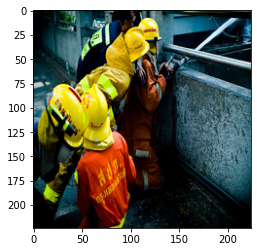

In [17]:
print('\npredicted caption:')
output_to_caption(outputs1, 30)
print("\n\nactual caption:")
tensor_to_caption(caption, 30)
print()
tensor_to_image(img_list, 30)


predicted caption:
a people are different street line in a different country are looking yellow and hats 

actual caption:
four people from a UNK station in a different country are wearing yellow hard hats while battling a fire 


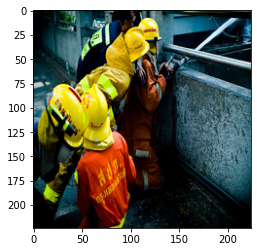

In [18]:
print('\npredicted caption:')
output_to_caption(outputs2, 30)
print("\n\nactual caption:")
tensor_to_caption(caption, 30)
print()
tensor_to_image(img_list, 30)

In [19]:
import math
k = 10
def beam_search(img):
            
            img = img.to(device)
            features = encoder(img.unsqueeze(0)) # [1,512,49,49]
            features = features.permute(0,2,3,1)    # [32,7,7,2048]
            features = features.view(-1, 49, 2048) # [32,196,512]
            
            inp = vocab.to_index('SOS') 
            
            hidden_state = torch.mean(features, dim = 1)    #[32,512]
            cell_state = torch.mean(features, dim = 1)      #[32,512]
            states = (hidden_state, cell_state)
            
            sequences = [[list(), 0.0, states]]

            for _ in range(84):

                all_candidates = list()

                for i in range(len(sequences)):
                    seq, score, states = sequences[i]        

                    if len(seq) != 0:
                        inp = seq[-1]
                        if vocab.to_word(int(inp)) == "EOS":
                            all_candidates.append(sequences[i])
                            continue

                    word_embeds = decoder.embed(torch.tensor([inp]).to(device))
                    states = decoder.lstm_cell(word_embeds, states)
                    context = decoder.attn(features, states[0], word_embeds, states[1])
                    out = torch.cat((context, states[0]), dim = 1)
                    out = decoder.fc_out(out)
                    
                    predictions = F.softmax(out, dim = 1).squeeze(0)
                    
                    #word_preds = np.argsort(predictions.cpu)[-k:]
                    _,word_preds = torch.topk(predictions.clone().detach().cpu(), k)
                
            
                    for j in word_preds:
                        candidate = (seq + [j], score - math.log(predictions[j]), states)
                        all_candidates.append(candidate)

                    ordered = sorted(all_candidates, key=lambda tup:tup[1]/(len(tup[0])))
                    sequences = ordered[:k]     

            output_arr = sequences[0][0]

            if vocab.to_word(int(sequences[0][0][-1])) == 'EOS':
                output_arr = sequences[0][0][:-1]

            if vocab.to_word(int(sequences[0][0][0])) == 'SOS':
                output_arr = output_arr[1:]    

            return [vocab.to_word(int(idx)) for idx in output_arr]

['a',
 'man',
 'in',
 'a',
 'white',
 'shirt',
 'and',
 'blue',
 'jeans',
 'is',
 'holding',
 'a',
 'small',
 'object',
 'in',
 'his',
 'left',
 'hand',
 'over',
 'the',
 'camera']

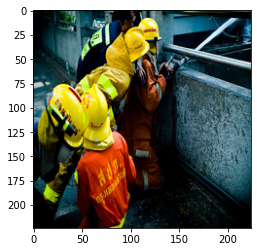

In [20]:
encoder = encoder.to(device)
decoder = decoder.to(device)
#for img_list,caption in trainloader:
img = img_list[30]
tensor_to_image(img_list, 30)
beam_search(img)